In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import math as m
from sklearn import svm
from matplotlib.colors import LogNorm

os.environ["CUDA_VISIBLE_DEVICES"] = '1,2,3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['OMP_NUM_THREADS'] = '16'
tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.threading.set_inter_op_parallelism_threads(16)
print(tf.__version__)
sns.set(font_scale=1.25, style='whitegrid')

2.1.0


In [3]:
def fileparser(path, dlist):
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)
    n = len(df)
    weight = int(round(np.mean(np.abs(df.pop('weight').to_numpy())) * 3 * 1e6 * n))
    df_test = df.sample(frac=0.2).reset_index(drop=True)
    df.drop(df_test.index, inplace=True)
    return df, df_test, weight

In [4]:
# dlist = ['etab2', 'etaaa', 'dphibb', 'etaa2', 'etab1', 'etaa1', 'nbjet']
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']
df_yb2, df_yb2_test, weight_yb2 = fileparser("ROOT/gencut_set5/yb2.csv", dlist)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("ROOT/gencut_set5/ybyt.csv", dlist)
df_yt2, df_yt2_test, weight_yt2 = fileparser("ROOT/gencut_set5/yt2.csv", dlist)
df_zh, df_zh_test, weight_zh = fileparser("ROOT/gencut_set5/zh.csv", dlist)
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("ROOT/gencut_set5/bbxaa.csv", dlist)

channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [5]:
def runBDT(df, rf=False, depth=30):
    mshap = True if depth <= 5 else False
    X = df.drop(columns=['class'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.1)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the decision tree
    """
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=100, criterion='gini', n_jobs=12)
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.1, objective='multi:softprob', num_class=nchannels,
                                         nthread=12, subsample=0.8, colsample_bytree=1, n_estimators=750)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=10, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
        # shap.summary_plot(shap_values, X_shap, plot_type='violin')
        shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=["bbxaa", "zh", "yt2", "ybyt", "yb2"], class_inds='original')
    return classifier, x_test, y_test

Accuracy Score: 71.45% 
Accuracy Score: 70.13% 


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


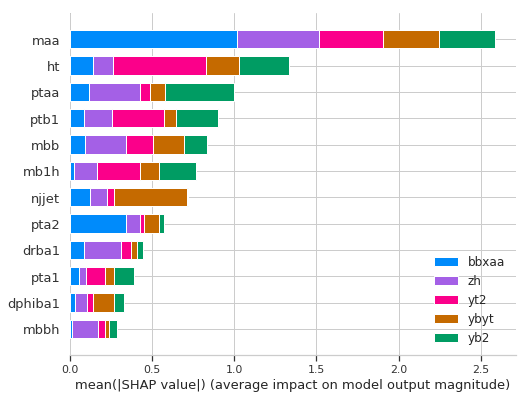

In [47]:
classifier, x_test, y_test = runBDT(df_train, rf=False, depth=10)
classifier, x_test, y_test = runBDT(df_train, rf=False, depth=30)

In [14]:
classifier, x_test, y_test = runBDT(df_train, rf=True, depth=50)

Accuracy Score: 70.80% 


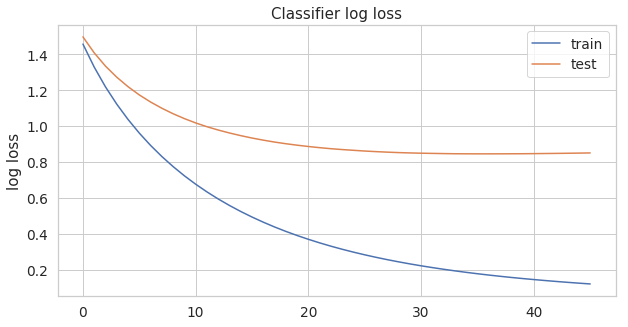

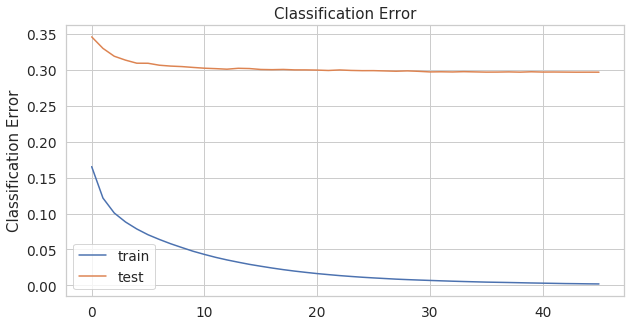

In [31]:
results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='test')
ax.legend()
    
plt.ylabel('log loss')
plt.title('Classifier log loss')
plt.show()
    

# plot classification error
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['merror'], label='train')
ax.plot(x_axis, results['validation_1']['merror'], label='test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('Classification Error')
plt.show()

In [15]:
comb_test = pd.concat([df_yb2_test, df_ybyt_test, df_yt2_test, df_zh_test, df_bbxaa_test])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 90.71% 


Accuracy Score for yb2: 69.23% 
Accuracy Score for ybyt: 63.73% 
Accuracy Score for yt2: 75.51% 
Accuracy Score for zh: 97.03% 
Accuracy Score for bbxaa: 92.66% 


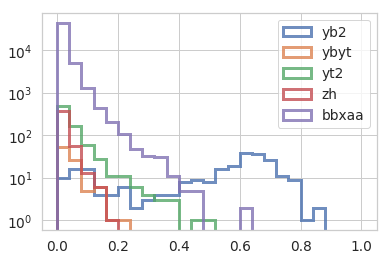

In [18]:
disc = 4
yb2_pred = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class']).values))))

ybyt_pred = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class']).values))))

yt2_pred = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class']).values))))

zh_pred = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class']).values))))

bbxaa_pred = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class']).values))))

yb2_pred = yb2_pred.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)
ybyt_pred = ybyt_pred.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True)
yt2_pred = yt2_pred.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True)
zh_pred = zh_pred.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True)
bbxaa_pred = bbxaa_pred.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True)

sns.distplot(yb2_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='yb2')
sns.distplot(ybyt_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='ybyt')
sns.distplot(yt2_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='yt2')
sns.distplot(zh_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='zh')
sns.distplot(bbxaa_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='bbxaa')
plt.legend()
plt.yscale('log')

In [19]:
cut = 0.5
bdt_n_yb2 = yb2_pred.loc[yb2_pred.iloc[:,-1] > cut].shape[0]
bdt_n_ybyt = ybyt_pred.loc[ybyt_pred.iloc[:,-1] > cut].shape[0]
bdt_n_yt2 = yt2_pred.loc[yt2_pred.iloc[:,-1] > cut].shape[0]
bdt_n_zh = zh_pred.loc[zh_pred.iloc[:,-1] > cut].shape[0]
bdt_n_bbxaa = bbxaa_pred.loc[bbxaa_pred.iloc[:,-1] > cut].shape[0]
sig = (bdt_n_yb2)/m.sqrt(bdt_n_yb2 + bdt_n_ybyt + bdt_n_yt2 + bdt_n_zh + bdt_n_bbxaa)
print(bdt_n_yb2, "yb2-like events.", bdt_n_ybyt, "ybyt-like event.", bdt_n_yt2,
      "yt2-like event.", bdt_n_zh, "zh-like event.", bdt_n_bbxaa, "bxaa event.")
print("sig/sqrt(sig+bkg): ", sig)

166 yb2-like events. 0 ybyt-like event. 1 yt2-like event. 0 zh-like event. 2 bxaa event.
sig/sqrt(sig+bkg):  12.76923076923077


In [122]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print('\nbaseline increased since learning times is approaching death')
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.ylim([0.5, 0.7])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.ylim([0.8, 1])
    plt.legend()
    plt.show()
    

In [200]:
def build_model(df):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(24, activation='relu', input_shape=[len(df.keys())-1]),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam(
    #                 learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    #                 name='Adam')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [201]:
model = build_model(df_yb2)
model.summary()    

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 24)                336       
_________________________________________________________________
dense_156 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_157 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_158 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_159 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_160 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_161 (Dense)            (None, 5)               

In [202]:
# learning_rate = 0.003
EPOCHS = 200000
patience = 50
df_train_set = df_train.copy(deep=True)
df_train_labels = df_train_set.pop('class')

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=640,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])

loss, accuracy = model.evaluate(df_yb2_test.iloc[:,:-1], df_yb2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yb2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_ybyt_test.iloc[:,:-1], df_ybyt_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for ybyt: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_yt2_test.iloc[:,:-1], df_yt2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yt2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_zh_test.iloc[:,:-1], df_zh_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for zh: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_bbxaa_test.iloc[:,:-1], df_bbxaa_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for bbxaa: {:4.2f}%".format(accuracy*100))

 epochs =  0  val_loss =  1.231657823670723
************************************************** epochs =  50  val_loss =  1.0688308179273063
************************************************** epochs =  100  val_loss =  0.931561198282182
************************************************** epochs =  150  val_loss =  0.8973131368292077
************************************************** epochs =  200  val_loss =  0.8772573713962721
************************************************** epochs =  250  val_loss =  0.8992813058295037
************************************************** epochs =  300  val_loss =  0.8757272731314951
************************************************** epochs =  350  val_loss =  0.8799235236303862
************************************************** epochs =  400  val_loss =  0.8789610659563475
************************************************** epochs =  450  val_loss =  0.8666534669252248
************************************************** epochs =  500  val_loss =  0.86822

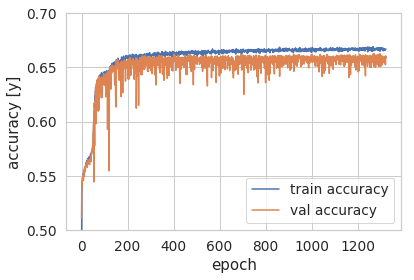

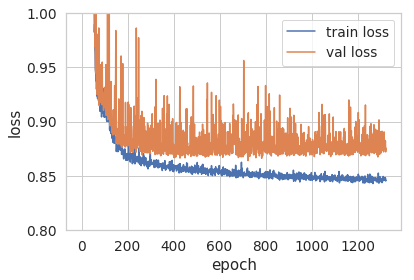

In [203]:
plot_history(history)

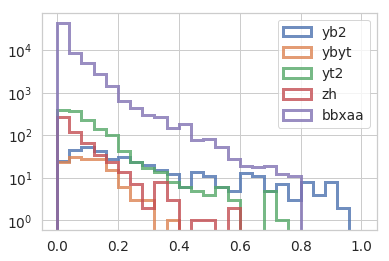

In [217]:
disc = 4
test_predictions_yb2 = model.predict(df_yb2_test.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_ybyt = model.predict(df_ybyt_test.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_yt2 = model.predict(df_yt2_test.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_zh = model.predict(df_zh_test.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_bbxaa = model.predict(df_bbxaa_test.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]


plt.figure()
plt.hist(test_predictions_yb2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='yb2')
plt.hist(test_predictions_ybyt, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='ybyt')
plt.hist(test_predictions_yt2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='yt2')
plt.hist(test_predictions_zh, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='zh')
plt.hist(test_predictions_bbxaa, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3, label='bbxaa')
plt.legend()
plt.yscale('log')

In [220]:
cut = 0.6
NN_n_yb2 = len(np.where(test_predictions_yb2 > cut)[0])
NN_n_ybyt = len(np.where(test_predictions_ybyt > cut)[0])
NN_n_yt2 = len(np.where(test_predictions_yt2 > cut)[0])
NN_n_zh = len(np.where(test_predictions_zh > cut)[0])
NN_n_bbxaa = len(np.where(test_predictions_bbxaa > cut)[0])
print(NN_n_yb2, "yb2-like events.", NN_n_ybyt, "ybyt-like event.", NN_n_yt2, "yt2-like event.",
      NN_n_zh, "zh-like event.", NN_n_bbxaa, "bbxaa event.")
print("sig/sqrt(sig+bkg): ",NN_n_yb2/m.sqrt(NN_n_yb2 + NN_n_ybyt + NN_n_yt2 + NN_n_zh + NN_n_bbxaa))



61 yb2-like events. 0 ybyt-like event. 6 yt2-like event. 0 zh-like event. 79 bbxaa event.
sig/sqrt(sig+bkg):  5.048395920474444


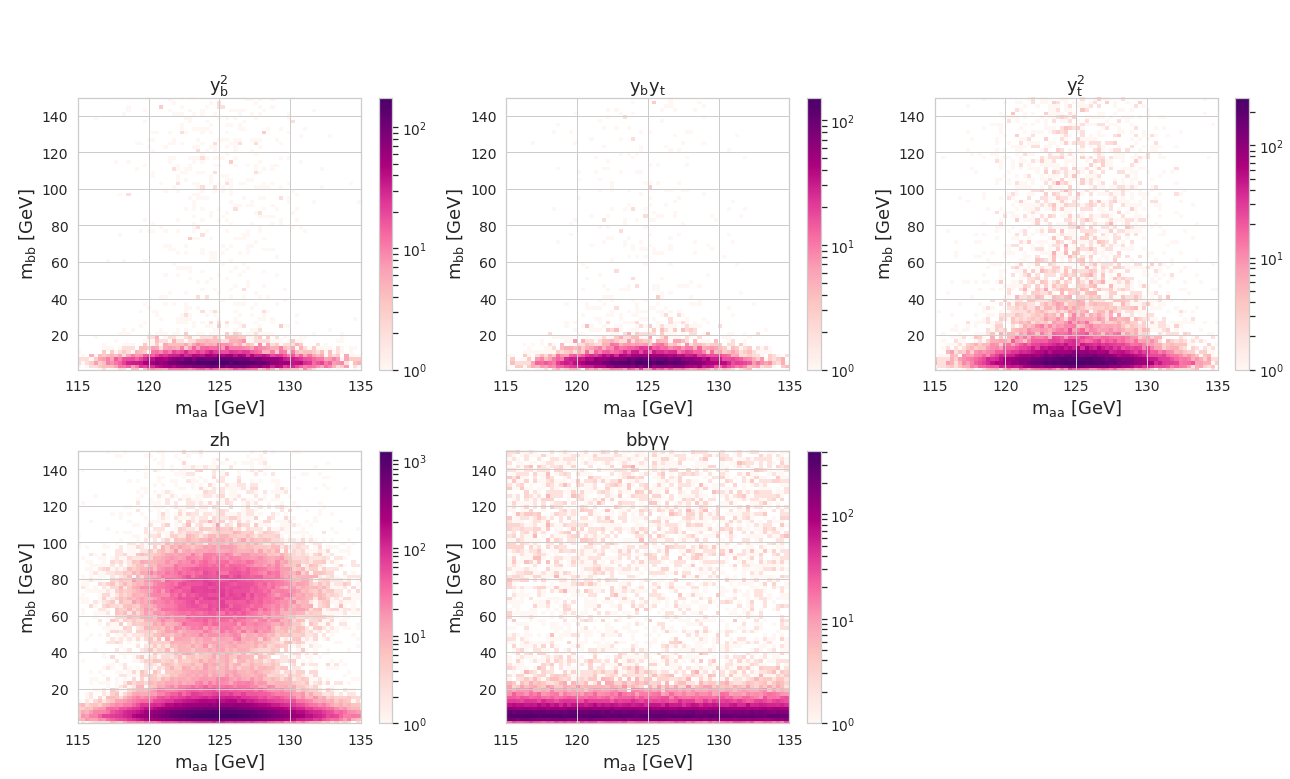

In [38]:
plt.figure(figsize=(18,10))
logs = False
plt.subplot(2,3,1)
plt.hist2d(df_yb2[df_yb2['mbb'] < 200].maa, df_yb2[df_yb2['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_b^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,2)
plt.hist2d(df_ybyt[df_ybyt['mbb'] < 200].maa, df_ybyt[df_ybyt['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_by_t$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,3)
plt.hist2d(df_yt2[df_yt2['mbb'] < 200].maa, df_yt2[df_yt2['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$y_t^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,4)
plt.hist2d(df_zh[df_zh['mbb'] < 200].maa, df_zh[df_zh['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$zh$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,5)
plt.hist2d(df_bbxaa[df_bbxaa['mbb'] < 200].maa, df_bbxaa[df_bbxaa['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$m_{bb}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,150)
plt.title(r'$bb\gamma\gamma$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.tight_layout()
plt.show()

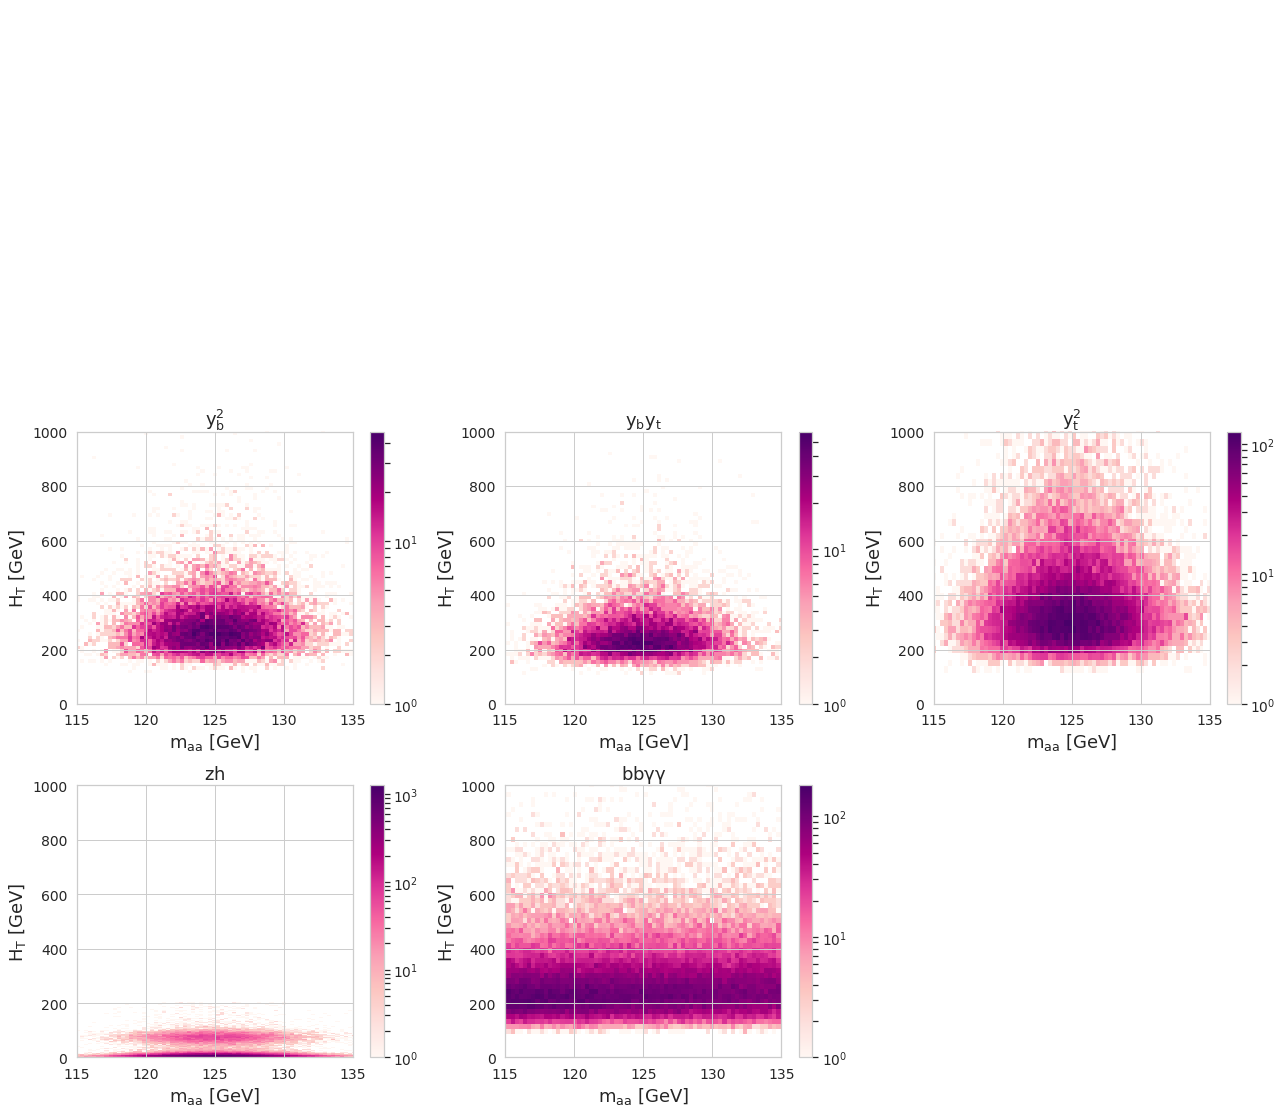

In [44]:
plt.figure(figsize=(18,10))
logs = False
plt.subplot(2,3,1)
plt.hist2d(df_yb2.maa, df_yb2.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_b^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,2)
plt.hist2d(df_ybyt.maa, df_ybyt.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_by_t$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,3)
plt.hist2d(df_yt2.maa, df_yt2.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$y_t^2$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,4)
plt.hist2d(df_zh[df_zh['mbb'] < 200].maa, df_zh[df_zh['mbb'] < 200].mbb, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$zh$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.subplot(2,3,5)
plt.hist2d(df_bbxaa.maa, df_bbxaa.ht, bins=100, cmap=plt.cm.RdPu, norm=LogNorm())
plt.xlabel(r'$m_{aa}$ [GeV]', fontsize=18)
plt.ylabel(r'$H_{T}$ [GeV]', fontsize=18)
if logs: plt.yscale('log')
plt.xlim(115,135)
plt.ylim(1,1000)
plt.title(r'$bb\gamma\gamma$', fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.colorbar()

plt.tight_layout()
plt.show()